In [16]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

Setting environment for Gordon
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of utilities2015 failed: Traceback (most recent call last):
  File "/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: __abstractmethods__
]


In [3]:
# Load atlas volume

# atlas_volume = bp.unpack_ndarray_file(os.path.join(volume_dir, 'MD589/volume_MD589_annotation_withOuterContour.bp'))
atlas_volume = bp.unpack_ndarray_file(volume_dir + '/atlasVolume_icp.bp')

atlas_ydim, atlas_xdim, atlas_zdim = atlas_volume.shape
atlas_centroid = np.array([.5*atlas_xdim, .5*atlas_ydim, .5*atlas_zdim])
print atlas_centroid

[ 303.   200.5  265.5]


In [7]:
available_labels_sided = [labels_sided[i-1] for i in np.unique(atlas_volume) if i > 0]
available_labels_unsided = set([labelMap_sidedToUnsided[name] for name in available_labels_sided ])

In [8]:
def parallel_where(name, num_samples=None):
    global atlas_volume, labels_sided_indices
    
    w = np.where(atlas_volume == labels_sided_indices[name])
    
    if num_samples is not None:
        n = len(w[0])
        sample_indices = np.random.choice(range(n), min(num_samples, n), replace=False)
        return np.c_[w[1][sample_indices].astype(np.int16), 
                     w[0][sample_indices].astype(np.int16), 
                     w[2][sample_indices].astype(np.int16)]
    else:
        return np.c_[w[1].astype(np.int16), w[0].astype(np.int16), w[2].astype(np.int16)]
    
t = time.time()

atlas_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(name_s, num_samples=int(1e5)) for name_s in available_labels_sided)
atlas_nzs = dict(zip(available_labels_sided, atlas_nzs))

sys.stderr.write('load atlas: %f seconds\n' % (time.time() - t)) #~ 7s

load atlas: 2.046726 seconds


In [11]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [12]:
# Center the nonzero voxels around atlas centroid
pts_centered = {name: (np.concatenate([atlas_nzs[n] for n in labelMap_unsidedToSided[name]]) - atlas_centroid).astype(np.int16) 
                         for name in available_labels_unsided}

In [13]:
# Set weights of structures
label_weights = {name: .1 if name == 'outerContour' else 1. for name in available_labels_unsided}

In [15]:
def compute_score_and_gradient(T):
    """Compute score and gradient."""
    global pts_centered
    
    score = 0
    dMdA = np.zeros((12,))
    
    for name in available_labels_unsided:
#         t1 = time.time()
    
        pts_prime = transform_points(T, pts_centered=pts_centered[name], c_prime=test_centroid)
        
        xs_prime, ys_prime, zs_prime = pts_prime.T.astype(np.int16)

        valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
                (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)
                   
        if np.count_nonzero(valid) > 0:

            xs_prime_valid = xs_prime[valid]
            ys_prime_valid = ys_prime[valid]
            zs_prime_valid = zs_prime[valid]
            
            voxel_probs_valid = volume2_allLabels[name][ys_prime_valid, xs_prime_valid, zs_prime_valid] / 1e4

            score += label_weights[name] * voxel_probs_valid.sum()
            
            Sx = dSdxyz[name][0, ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Sy = dSdxyz[name][1, ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Sz = dSdxyz[name][2, ys_prime_valid, xs_prime_valid, zs_prime_valid]
            
            dxs, dys, dzs = pts_centered[name][valid].T

            q = np.c_[Sx*dxs, Sx*dys, Sx*dzs, Sx, 
                          Sy*dxs, Sy*dys, Sy*dzs, Sy,
                          Sz*dxs, Sz*dys, Sz*dzs, Sz]        
            
            dMdA += label_weights[name] * q.sum(axis=0)
            
            del voxel_probs_valid, q, Sx, Sy, Sz, dxs, dys, dzs, xs_prime_valid, ys_prime_valid, zs_prime_valid
        
#         sys.stderr.write('########### %s: %f seconds\n' % (labels[l], time.time() - t1))
        
        del valid, xs_prime, ys_prime, zs_prime, pts_prime
        
    return score, dMdA

def compute_score(T):
    """Compute score."""    
    score = 0
    for name in available_labels_unsided:
        
        pts_prime = transform_points(T, pts_centered=pts_centered[name], c_prime=test_centroid)
    
        xs_prime, ys_prime, zs_prime = pts_prime.T.astype(np.int16)
        
        valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)
            
        voxel_probs_valid = volume2_allLabels[name][ys_prime[valid], xs_prime[valid], zs_prime[valid]] / 1e4

        score += label_weights[name] * voxel_probs_valid.sum()
                
        del voxel_probs_valid, valid, xs_prime, ys_prime, zs_prime, pts_prime
                
    return score

def compute_score_gradient(T):
    """Compute gradient of score."""

    dMdA = np.zeros((12,))

    for name in available_labels_unsided:
#       
        pts_prime = transform_points(T, pts_centered=pts_centered[name], c_prime=test_centroid)

        xs_prime, ys_prime, zs_prime = pts_prime.T.astype(np.int16)

        valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)
            
        if np.count_nonzero(valid) > 0:
            
            xs_prime_valid = xs_prime[valid]
            ys_prime_valid = ys_prime[valid]
            zs_prime_valid = zs_prime[valid]
            
            Sx = dSdxyz[name][0, ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Sy = dSdxyz[name][1, ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Sz = dSdxyz[name][2, ys_prime_valid, xs_prime_valid, zs_prime_valid]
               
            dxs, dys, dzs = pts_centered[name][valid].T
                        
            dMdA += label_weights[name] * np.c_[Sx*dxs, Sx*dys, Sx*dzs, Sx, 
                          Sy*dxs, Sy*dys, Sy*dzs, Sy,
                          Sz*dxs, Sz*dys, Sz*dzs, Sz].sum(axis=0)
            
    return dMdA

In [ ]:
def compute_score_hessian(T):
    
    Tm = np.reshape(T, (3,4))
    tx, ty, tz = Tm[:, 3]
    A = Tm[:, :3]

    d2MdT2 = np.zeros((12, 12))
    
    for l in range(1, n_labels):

        xs_prime, ys_prime, zs_prime = (np.dot(A, ds[l-1]) + \
                                        np.asarray([tx + test_cx, 
                                                    ty + test_cy, 
                                                    tz + test_cz])[:,np.newaxis]).astype(np.int)

        valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)

        if np.count_nonzero(valid) > 0:

            xs_prime_valid = xs_prime[valid]
            ys_prime_valid = ys_prime[valid]
            zs_prime_valid = zs_prime[valid]
            
            dxs, dys, dzs = ds[l-1][:, valid]

            Sxx_full, Sxy_full, Sxz_full, Syx_full, Syy_full, Syz_full, Szx_full, Szy_full, Szz_full = d2Sdxyz2[l-1]
            Sxx = Sxx_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Sxy = Sxy_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Sxz = Sxz_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Syx = Syx_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Syy = Syy_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Syz = Syz_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Szx = Szx_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Szy = Szy_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Szz = Szz_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]

            rx = np.c_[Sxx*dxs, Sxx*dys, Sxx*dzs, Sxx, Sxy*dxs, Sxy*dys, Sxy*dzs, Sxy, Sxz*dxs, Sxz*dys, Sxz*dzs, Sxz]
            ry = np.c_[Syx*dxs, Syx*dys, Syx*dzs, Syx, Syy*dxs, Syy*dys, Syy*dzs, Syy, Syz*dxs, Syz*dys, Syz*dzs, Syz]
            rz = np.c_[Szx*dxs, Szx*dys, Szx*dzs, Szx, Szy*dxs, Szy*dys, Szy*dzs, Szy, Szz*dxs, Szz*dys, Szz*dzs, Szz]
            r1 = (rx*dxs[:,None]).sum(axis=0)
            r2 = (rx*dys[:,None]).sum(axis=0)
            r3 = (rx*dzs[:,None]).sum(axis=0)
            r4 = rx.sum(axis=0)
            r5 = (ry*dxs[:,None]).sum(axis=0)
            r6 = (ry*dys[:,None]).sum(axis=0)
            r7 = (ry*dzs[:,None]).sum(axis=0)
            r8 = ry.sum(axis=0)
            r9 = (rz*dxs[:,None]).sum(axis=0)
            r10 = (rz*dys[:,None]).sum(axis=0)
            r11 = (rz*dzs[:,None]).sum(axis=0)
            r12 = rz.sum(axis=0)
            
            d2MdT2_l = np.vstack([r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12])
    
        d2MdT2 += d2MdT2_l
    
    return d2MdT2

In [ ]:
# BFGS

from scipy.optimize import fmin_bfgs, fmin_ncg, fmin_l_bfgs_b, fmin_cg

import collections, functools

def func_wrapper(f, cache_size=10):
    evals = {}
    last_points = collections.deque()

    def get(pt, which):
        s = pt.tostring() # get binary string of numpy array, to make it hashable
        if s not in evals:
            evals[s] = f(pt)
            last_points.append(s)
            if len(last_points) >= cache_size:
                del evals[last_points.popleft()]
        return evals[s][which]

    return functools.partial(get, which=0), functools.partial(get, which=1), functools.partial(get, which=2)

tx_best, ty_best, tz_best = params_best_upToNow
T_best = np.r_[1,0,0, tx_best, 0,1,0, ty_best, 0,0,1, tz_best]

t = time.time()

# f_, fprime = func_wrapper(compute_score_and_gradient_minus)

f_, fprime, fhess = func_wrapper(compute_score_and_gradient_and_hessian_minus)

# res = fmin_ncg(f=f_, x0=T_best, fprime=fprime, fhess=fhess, maxiter=100, epsilon=1e-3, full_output=True)
# res = fmin_ncg(f=compute_score_minus, x0=T_best, fprime=compute_score_gradient_minus, maxiter=10, epsilon=1e-2)

res = fmin_cg(f=f_, x0=T_best, fprime=fprime, maxiter=10)

# res = fmin_bfgs(f=f_, x0=T_best, fprime=fprime, maxiter=10)

# res = fmin_l_bfgs_b(func=compute_score_minus, x0=T_best, maxiter=10, approx_grad=True)

sys.stderr.write('optimize: %f seconds\n' % (time.time() - t))

In [ ]:
# Numerical differentiation

import numdifftools as nd
g = nd.Gradient(compute_score, step=np.r_[1e-1, 1e-1, 1e-1, 5,
                                          1e-1, 1e-1, 1e-1, 5,
                                          1e-1, 1e-1, 1e-1, 5])
g(T_final).reshape((3,4))

h = nd.Hessdiag(compute_score, step=np.r_[1e-1, 1e-1, 1e-1, 5,
                                          1e-1, 1e-1, 1e-1, 5,
                                          1e-1, 1e-1, 1e-1, 5])
h(T_final).reshape((3,4))

load score volumes: 27.534788 seconds
load gradient RtTg: 9.887150 seconds
load gradient VLL: 9.731063 seconds
load gradient Tz: 6.745456 seconds
load gradient LC: 9.954948 seconds
load gradient 7N: 11.525541 seconds
load gradient Amb: 9.783488 seconds
load gradient 6N: 21.602796 seconds
load gradient AP: 21.822907 seconds
load gradient 5N: 25.945059 seconds
load gradient 12N: 23.566005 seconds
load gradient 7n: 19.242286 seconds
load gradient R: 17.520688 seconds
load gradient Pn: 23.521699 seconds
load gradient LRt: 24.501832 seconds
overall: 235.356896 seconds
INFO:__main__:grid search iteration 0


test_xdim, test_ydim, test_zdim: 838 460 454
test_centroid: [ 419.  230.  227.]


grid search: 27.620252 seconds
INFO:__main__:0.000000 46.801414
INFO:__main__:-111.894222 37.912516 -15.082959
INFO:__main__:

INFO:__main__:grid search iteration 1
grid search: 21.448890 seconds
INFO:__main__:46.801414 48.977577
INFO:__main__:-94.038851 43.683430 15.596275
INFO:__main__:

INFO:__main__:grid search iteration 2
grid search: 16.866659 seconds
INFO:__main__:

INFO:__main__:grid search iteration 3
grid search: 13.159560 seconds
INFO:__main__:48.977577 50.862104
INFO:__main__:-95.671343 28.265419 -11.426957
INFO:__main__:

INFO:__main__:grid search iteration 4
grid search: 10.166200 seconds
INFO:__main__:50.862104 54.893005
INFO:__main__:-91.616441 36.602228 -1.911909
INFO:__main__:

INFO:__main__:iteration 0
INFO:__main__:score: 54.893005
INFO:__main__:

INFO:__main__:iteration 1
INFO:__main__:score: 37.657516
INFO:__main__:

INFO:__main__:iteration 2
INFO:__main__:score: 64.124519
INFO:__main__:

INFO:__main__:iteration 3
INFO:__main__:score: 67.099365
INFO:__main__:

INF

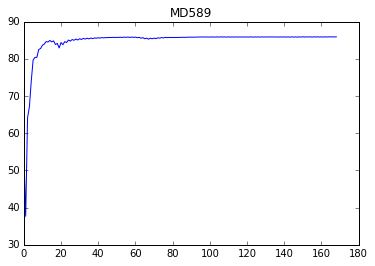

In [18]:
# for stack in ['MD594', 'MD593', 'MD585', 'MD592', 'MD590', 'MD591', 'MD595', 'MD598', 'MD602']:
for stack in ['MD589']:
    
    ################# Load Test Volume ######################

    t = time.time()

    volume2_allLabels = {}

    for name in available_labels_unsided:

        if name == 'BackG':
            continue

        volume2_roi = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_scoreVolume_%(label)s.bp' % \
                                                          {'stack': stack, 'label': name})).astype(np.float16)
        volume2_allLabels[name] = volume2_roi
        del volume2_roi

    test_ydim, test_xdim, test_zdim = volume2_allLabels.values()[0].shape
    test_centroid = np.r_[.5*test_xdim, .5*test_ydim, .5*test_zdim]

    print 'test_xdim, test_ydim, test_zdim:', test_xdim, test_ydim, test_zdim
    print 'test_centroid:', test_centroid

    sys.stderr.write('load score volumes: %f seconds\n' % (time.time() - t))

    ###################### Load Gradient #####################

    dSdxyz = {name: np.empty((3, test_ydim, test_xdim, test_zdim), dtype=np.float16) for name in available_labels_unsided}

    t1 = time.time()

    for name in available_labels_unsided:

        if name == 'BackG':
            continue

        t = time.time()

        dSdxyz[name][0] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gx.bp' % {'stack':stack, 'label':name})
        dSdxyz[name][1] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gy.bp' % {'stack':stack, 'label':name})
        dSdxyz[name][2] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gz.bp' % {'stack':stack, 'label':name})

        sys.stderr.write('load gradient %s: %f seconds\n' % (name, time.time() - t)) # ~6s

    sys.stderr.write('overall: %f seconds\n' % (time.time() - t1)) # ~100s
    
    handler = logging.FileHandler(atlasAlignOptLogs_dir + '/%(stack)s_atlasAlignOpt.log' % {'stack': stack})
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

    ################# Random Grid Search ######################

    grid_search_iteration_number = 5
    # grid_search_iteration_number = 1

    params_best_upToNow = (0, 0, 0)
    score_best_upToNow = 0

    init_n = 1000

    for iteration in range(grid_search_iteration_number):

        logger.info('grid search iteration %d', iteration)

        init_tx, init_ty, init_tz  = params_best_upToNow

        n = int(init_n*np.exp(-iteration/3.))

        sigma_tx = 300*np.exp(-iteration/3.)
        sigma_ty = 300*np.exp(-iteration/3.)
        sigma_tz = 100*np.exp(-iteration/3.)

        tx_grid = init_tx + sigma_tx * (2 * np.random.random(n) - 1)
        ty_grid = init_ty + sigma_ty * (2 * np.random.random(n) - 1)
        tz_grid = init_tz + sigma_tz * (2 * np.random.random(n) - 1)

        samples = np.c_[tx_grid, ty_grid, tz_grid]

        import time

        t = time.time()
        scores = Parallel(n_jobs=8)(delayed(compute_score)(np.r_[1, 0, 0, tx, 0, 1, 0, ty, 0, 0, 1, tz])
                                    for tx, ty, tz in samples)

    #     scores = []
    #     for tx, ty, tz in samples:
    #         scores.append(compute_score([1, 0, 0, tx, 0, 1, 0, ty, 0, 0, 1, tz]))

        sys.stderr.write('grid search: %f seconds\n' % (time.time() - t)) # ~23s

        score_best = np.max(scores)

        tx_best, ty_best, tz_best = samples[np.argmax(scores)]

        if score_best > score_best_upToNow:
            logger.info('%f %f', score_best_upToNow, score_best)

            score_best_upToNow = score_best
            params_best_upToNow = tx_best, ty_best, tz_best

            logger.info('%f %f %f', tx_best, ty_best, tz_best)

        logger.info('\n')
        
    ################# Gradient Descent ######################

    lr1, lr2 = (10., 1e-1)
    # lr1, lr2 = (1., 1e-3)

    # auto_corr = .95

    max_iter_num = 1000
    fudge_factor = 1e-6 #for numerical stability
    dMdA_historical = np.zeros((12,))

    tx_best, ty_best, tz_best = params_best_upToNow
    T_best = np.r_[1,0,0, tx_best, 0,1,0, ty_best, 0,0,1, tz_best]

    lr = np.r_[lr2, lr2, lr2, lr1, lr2, lr2, lr2, lr1, lr2, lr2, lr2, lr1]

    score_best = 0

    scores = []

    for iteration in range(max_iter_num):

        logger.info('iteration %d', iteration)

    #     t = time.time()
        s, dMdA = compute_score_and_gradient(T_best)
    #     sys.stderr.write('compute_score_and_gradient: %f seconds\n' % (time.time() - t)) #~ 2s/iteration or ~.5s: 1e5 samples per landmark

        dMdA_historical += dMdA**2
    #     dMdA_historical = auto_corr * dMdA_historical + (1-auto_corr) * dMdA**2

        dMdA_adjusted = dMdA / (fudge_factor + np.sqrt(dMdA_historical))

        T_best += lr*dMdA_adjusted

    #         logger.info('A: ' + ' '.join(['%f']*12) % tuple(A_best))
    #         logger.info('dMdA adjusted: ' + ' '.join(['%f']*12) % tuple(dMdA_adjusted))

        logger.info('score: %f', s)
        scores.append(s)

        logger.info('\n')

        history_len = 50
        if iteration > 100:
            if np.abs(np.mean(scores[iteration-history_len:iteration]) - \
                      np.mean(scores[iteration-2*history_len:iteration-history_len])) < 1e-1:
                break

        if s > score_best:
    #             logger.info('Current best')
            best_gradient_descent_params = T_best
            score_best = s

    plt.title('%s' % stack);
    plt.plot(scores);
    plt.show();
    
    del volume2_allLabels, dSdxyz
    
    ################# Save results ###############
    
#     np.save(atlasAlignOptLogs_dir + '/%(stack)s_scoreEvolutions.npy' % {'stack':stack}, scores)
    
#     create_if_not_exists(os.path.join(atlasAlignParams_dir + '/' + stack))
#     with open(os.path.join(atlasAlignParams_dir, '%(stack)s/%(stack)s_3dAlignParams.txt' % {'stack':stack}), 'w') as f:

#         f.writelines(' '.join(['%f']*len(best_gradient_descent_params)) % tuple(best_gradient_descent_params) + '\n')
#         f.write((' '.join(['%d']*3)+'\n') % tuple([atlas_xdim, atlas_ydim, atlas_zdim]))
#         f.write((' '.join(['%.1f']*3)+'\n') % tuple(atlas_centroid))    
#         f.write((' '.join(['%d']*3)+'\n') % tuple([test_xdim, test_ydim, test_zdim]))
#         f.write((' '.join(['%.1f']*3)+'\n') % tuple(test_centroid))